In [75]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
# key metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
# roc and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# f score 
from sklearn.metrics import f1_score
# classification report
from sklearn.metrics import classification_report





In [76]:
# import the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
gen_sub_data = pd.read_csv('gender_submission.csv')

In [77]:
# add the survival colum back into the test data
test_data = pd.merge(test_data, gen_sub_data, how='left')


In [78]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [79]:
print(f'Taining set contains {len(train_data)}')
print(f'Testing set contains {len(test_data)}')
total_entries = len(train_data) + len(test_data) 
print(f'{round(len(train_data)/total_entries*100)}% of the data is in the training set')
print(f'{round(len(test_data)/total_entries*100)}% of the data is in the testing set')

Taining set contains 891
Testing set contains 418
68% of the data is in the training set
32% of the data is in the testing set


In [80]:
train_data.head()
#SibSp = number of siblings/spouses aboard
#Parch = number of parents/children aboard
#Ticket = ticket number
#Fare = passenger fare
#Cabin = cabin number
#Embarked = port they embarked from
#pclass = passenger class

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [81]:
# create a column called Alone where 1 = alone and 0 = not alone
train_data['Alone'] = np.where((train_data['SibSp'] + train_data['Parch']) > 0, 0, 1)
test_data['Alone'] = np.where((test_data['SibSp'] + test_data['Parch']) > 0, 0, 1)

In [82]:
# drop SibSp and Parch
train_data.drop(['SibSp', 'Parch', 'Ticket'], axis=1, inplace=True)
test_data.drop(['SibSp', 'Parch', 'Ticket'], axis=1, inplace=True)

In [83]:
# check for null values
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
Fare             0
Cabin          687
Embarked         2
Alone            0
dtype: int64

In [84]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
Fare             1
Cabin          327
Embarked         0
Survived         0
Alone            0
dtype: int64

In [85]:
# what percentage of the data is missing in each column
train_data.isnull().sum() / len(train_data) * 100


PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
Alone           0.000000
dtype: float64

In [86]:
test_data.isnull().sum() / len(test_data) * 100

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
Survived        0.000000
Alone           0.000000
dtype: float64

In [87]:
# too much of the cabin data is missing to be useful lets drop it
train_data.drop('Cabin', axis=1, inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

In [88]:
# I want to isolate the titles from the names to help replace the missing age data
train_data['First Name'] = train_data['Name'].str.split(',').str[1]
train_data['Title'] = train_data['First Name'].str.split('.').str[0]
#new_train['Title'] = new_train['Title'].str.strip()
train_data['Title'].value_counts()


 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Mlle              2
 Major             2
 Col               2
 the Countess      1
 Capt              1
 Ms                1
 Sir               1
 Lady              1
 Mme               1
 Don               1
 Jonkheer          1
Name: Title, dtype: int64

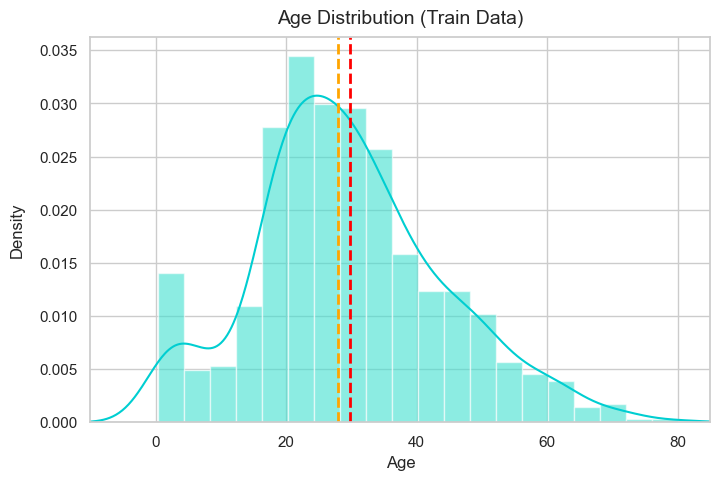

In [89]:
# checking the distribution of the age column
fig, ax = plt.subplots(figsize=(8, 5))
train_data['Age'].hist(bins=20,  density=True, stacked=True, color='turquoise', alpha=0.6)
train_data['Age'].plot(kind='density', color='darkturquoise')

age_mean = train_data['Age'].mean()
age_median = train_data['Age'].median()

plt.axvline(age_mean, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(age_median, color='orange', linestyle='dashed', linewidth=2, label='Median')

ax.set_xlim(-10, 85)

ax.set_xlabel('Age')
ax.set_ylabel('Density',labelpad=10)
ax.set_title('Age Distribution (Train Data)', fontsize=14,pad=10)
plt.show()


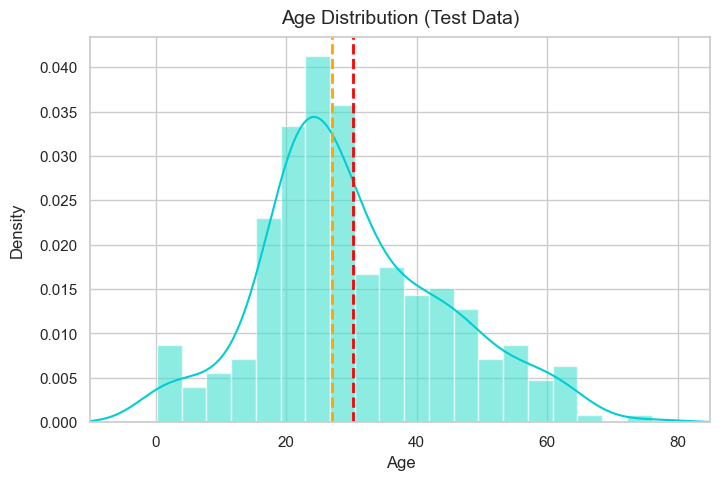

In [90]:
fig, ax = plt.subplots(figsize=(8, 5))
test_data['Age'].hist(bins=20,  density=True, stacked=True, color='turquoise', alpha=0.6)
test_data['Age'].plot(kind='density', color='darkturquoise')

test_age_mean = test_data['Age'].mean()
test_age_median = test_data['Age'].median()

plt.axvline(test_age_mean, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(test_age_median, color='orange', linestyle='dashed', linewidth=2, label='Median')

ax.set_xlim(-10, 85)

ax.set_xlabel('Age')
ax.set_ylabel('Density',labelpad=10)
ax.set_title('Age Distribution (Test Data)', fontsize=14,pad=10)
plt.show()

The age data overall is skewed to the right so I should replace the null values with the median figure to prevent to much disturbance. 

In [91]:
# replacing the age date null values with the median age
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)

In [92]:
# what is the total number of missing embarked values
print(train_data['Embarked'].isnull().sum())
print(test_data['Embarked'].isnull().sum())

# what is the total number of missing fare values
print(train_data['Fare'].isnull().sum())
print(test_data['Fare'].isnull().sum())

2
0
0
1


Removing the two missing values from embarked column in the train dataset &
the one missing value from the fare column in the test dataset

In [93]:
train_data = train_data.dropna(subset=['Embarked'])
test_data = test_data.dropna(subset=['Fare'])

In [94]:
# drop passenger id from the data sets
train_data.drop('PassengerId', axis=1, inplace=True)
test_data.drop('PassengerId', axis=1, inplace=True)

In [95]:
# drop the name column
train_data.drop('Name', axis=1, inplace=True)
test_data.drop('Name', axis=1, inplace=True)

train_data.drop('First Name', axis=1, inplace=True)

train_data.drop('Title', axis=1, inplace=True)



/var/folders/x7/4frtg_jx34g69lycmb25nq5m0000gn/T/ipykernel_2370/1272062281.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_data.corr()
/var/folders/x7/4frtg_jx34g69lycmb25nq5m0000gn/T/ipykernel_2370/1272062281.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(), annot=True, cmap='RdBu', mask=matrix, center = -0.15)


<AxesSubplot: >

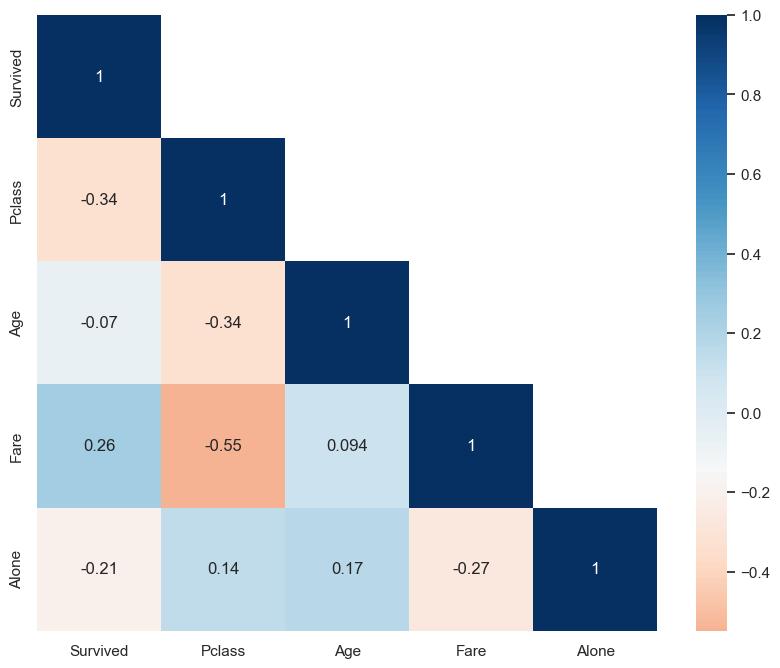

In [96]:
# lets see the correlation between the columns 
plt.figure(figsize=(10, 8))

corr = train_data.corr()
matrix = np.triu(corr)
np.fill_diagonal(matrix, False)

# change the order of the column names to match the correlation matrix
cols = ['Fare', 'Age', 'Survived', 'Pclass', 'Alone']

sns.heatmap(train_data.corr(), annot=True, cmap='RdBu', mask=matrix, center = -0.15)





In [97]:
test_data.head()

,Pclass,Sex,Age,Fare,Embarked,Survived,Alone
0,3,male,34.5,7.8292,Q,0,1
1,3,female,47.0,7.0000,S,1,0
2,2,male,62.0,9.6875,Q,0,1
3,3,male,27.0,8.6625,S,0,1
4,3,female,22.0,12.2875,S,1,0


In [98]:
# create new columns that will convert the string columns into boolean columns

# Is Female
train_data['is Female'] = np.where(train_data['Sex']=='female', 1, 0)
test_data['is Female'] = np.where(test_data['Sex']=='female', 1, 0)

# Is Male
train_data['is Male'] = np.where(train_data['Sex']=='male', 1, 0)
test_data['is Male'] = np.where(test_data['Sex']=='male', 1, 0)

# Embarked from S = Southampton 
train_data['Southampton'] = np.where(train_data['Embarked']=='S', 1, 0)
test_data['Southampton'] = np.where(test_data['Embarked']=='S', 1, 0)

# Embarked from C = Cherbourg
train_data['Cherbourg'] = np.where(train_data['Embarked']=='C', 1, 0)
test_data['Cherbourg'] = np.where(test_data['Embarked']=='C', 1, 0)

# Embarked from  Q = Queenstown
train_data['Queenstown'] = np.where(train_data['Embarked']=='Q', 1, 0)
test_data['Queenstown'] = np.where(test_data['Embarked']=='Q', 1, 0)

# Passenger Class 1 
train_data['First Class'] = np.where(train_data['Pclass']==1, 1, 0)
test_data['First Class'] = np.where(test_data['Pclass']==1, 1, 0)

# Passenger Class 2 
train_data['Second Class'] = np.where(train_data['Pclass']==2, 1, 0)
test_data['Second Class'] = np.where(test_data['Pclass']==2, 1, 0)

# Passenger Class 3 
train_data['Third Class'] = np.where(train_data['Pclass']==3, 1, 0)
test_data['Third Class'] = np.where(test_data['Pclass']==3, 1, 0)

In [99]:
# scale the age and fare columns to between 0 and 1
# create a variable to hold the columns to be scaled
columns_to_scale = ['Age', 'Fare']
# create a variable to hold the new columns that will contain the scaled values
normalised_columns = ['Norm_' + col for col in columns_to_scale]
# create a MinMaxScaler object
scaler = MinMaxScaler()

# fit the scaler to the training data
scaler.fit(train_data[columns_to_scale])
# transform the data
train_data[normalised_columns] = scaler.transform(train_data[columns_to_scale])

# fit the scaler to the testing data
scaler.fit(test_data[columns_to_scale])
# transform the data
test_data[normalised_columns] = scaler.transform(test_data[columns_to_scale])


In [100]:
g = 50 
scaler = MinMaxScaler()
print(scaler.fit(g))

ValueError: Expected 2D array, got scalar array instead:
array=50.0.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
train_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Alone,is Female,is Male,Southampton,Cherbourg,Queenstown,First Class,Second Class,Third Class,Norm_Age,Norm_Fare
0,0,3,male,22.0,7.2500,S,0,0,1,1,0,0,0,0,1,0.271174,0.014151
1,1,1,female,38.0,71.2833,C,0,1,0,0,1,0,1,0,0,0.472229,0.139136
2,1,3,female,26.0,7.9250,S,1,1,0,1,0,0,0,0,1,0.321438,0.015469
3,1,1,female,35.0,53.1000,S,0,1,0,1,0,0,1,0,0,0.434531,0.103644
4,0,3,male,35.0,8.0500,S,1,0,1,1,0,0,0,0,1,0.434531,0.015713


In [ ]:
test_data.head()

,Pclass,Sex,Age,Fare,Embarked,Survived,Alone,is Female,is Male,Southampton,Cherbourg,Queenstown,First Class,Second Class,Third Class,Norm_Age,Norm_Fare
0,3,male,34.5,7.8292,Q,0,1,0,1,0,0,1,0,0,1,0.452723,0.015282
1,3,female,47.0,7.0000,S,1,0,1,0,1,0,0,0,0,1,0.617566,0.013663
2,2,male,62.0,9.6875,Q,0,1,0,1,0,0,1,0,1,0,0.815377,0.018909
3,3,male,27.0,8.6625,S,0,1,0,1,1,0,0,0,0,1,0.353818,0.016908
4,3,female,22.0,12.2875,S,1,0,1,0,1,0,0,0,0,1,0.287881,0.023984


In [ ]:
# test and traing the new data columns using logistic regression

X = train_data.iloc[:,6:17]
y = train_data['Survived']

# split the data into training and testing data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = train_data.iloc[:,6:17]
X_test = test_data.iloc[:,6:17]

y_train = train_data['Survived']
y_test = test_data['Survived'] #<<< incorrect data


In [ ]:
# scale the data
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

using the standard scaler on X_train and X_test reduced the model efficiency by 1% 

In [ ]:

# logistic regression

classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
# make predictions
Y_pred = classifier.predict(X_test) # if you want to test new data this is where you input it
# put results in a dataframe
df = pd.DataFrame({'Actual': y_test, 'Predicted': Y_pred})
df

,Actual,Predicted
0,0,0
1,1,0
2,0,0
3,0,0
4,1,1
...,...,...
413,0,0
414,1,1
415,0,0
416,0,0


In [ ]:
# check the accuracy of the model
accuracy = accuracy_score(y_test, Y_pred)
#print('Accuracy: ', metrics.accuracy_score(y_test, Y_pred))
accuracy_perc = str(round(accuracy*100)) + '%'

print('Accuracy: ', accuracy_perc)

Accuracy:  96%


In [ ]:
score = classifier.score(X_train, y_train)
print('Score: ', score)


Score:  0.7941507311586051


<AxesSubplot: >

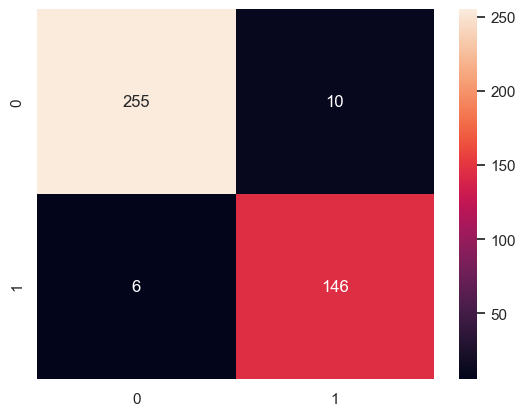

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, Y_pred) 
cm
sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
# Get the true + false, positives and negatives
tn = cm[0][0]
tp = cm[1][1]
fn = cm[1][0]
fp = cm[0][1]

In [103]:
# calculate precision, recall and specificity
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
print('Precision: ', precision, ' (How many items did we predict correctly are actually correct?)')
print('Recall: ', recall, '(The amount of correctly predicted items out of all the items.)')
print('Specificity: ', specificity, '(How many negatives were correctly predicted out of all the negatives?)')

Precision:  0.9358974358974359  (How many items did we predict correctly are actually correct?)
Recall:  0.9605263157894737 (The amount of correctly predicted items out of all the items.)
Specificity:  0.9622641509433962 (How many negatives were correctly predicted out of all the negatives?)


In [106]:
# calculate auc
auc = roc_auc_score(y_test, Y_pred)
print('AUC: ', auc)

AUC:  0.961395233366435


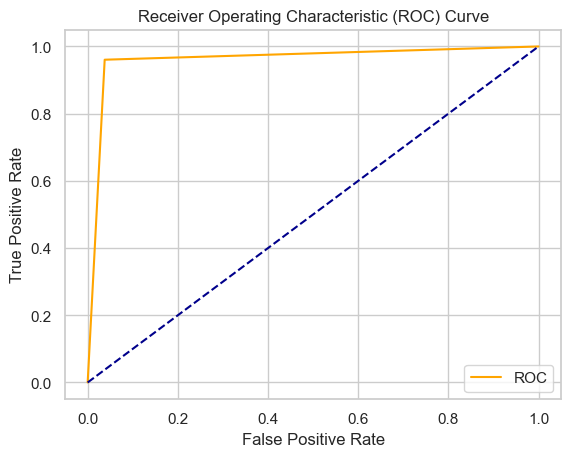

In [110]:
# plot the ROC curve
fpr, tpr = roc_curve(y_test, Y_pred)[0:2]
plt.plot(fpr,tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [115]:
# calculate the f1 score
f1 = f1_score(y_test, Y_pred)
print('F1 Score: ', f1.round(2))
print('This is the harmonic mean of precision and recall.')

F1 Score:  0.95
This is the harmonic mean of precision and recall.


In [112]:
# Confusion matrix interpretation

print('There are ', tn,' true negatives and ', fn,' false negatives. ')
print('There are ', tp,' true positives and ', fp,' false positives. ')
print('This is a highly promising result. ')

There are  255  true negatives and  6  false negatives. 
There are  146  true positives and  10  false positives. 
This is a highly promising result. 


In [116]:
# create a classification report
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       265
           1       0.94      0.96      0.95       152

    accuracy                           0.96       417
   macro avg       0.96      0.96      0.96       417
weighted avg       0.96      0.96      0.96       417



In [ ]:
print(f'X_train:{X_train}')

X_train:     Alone  is Female  is Male  Southampton  Cherbourg  Queenstown  \
0        0          0        1            1          0           0   
1        0          1        0            0          1           0   
2        1          1        0            1          0           0   
3        0          1        0            1          0           0   
4        1          0        1            1          0           0   
..     ...        ...      ...          ...        ...         ...   
886      1          0        1            1          0           0   
887      1          1        0            1          0           0   
888      0          1        0            1          0           0   
889      1          0        1            0          1           0   
890      1          0        1            0          0           1   

     First Class  Second Class  Third Class  Norm_Age  Norm_Fare  
0              0             0            1  0.271174   0.014151  
1              1 

In [ ]:
print(f'X_test:{X_test}')

X_test:     Alone  is Female  is Male  Southampton  Cherbourg  Queenstown  \
0        1          0        1            0          0           1   
1        0          1        0            1          0           0   
2        1          0        1            0          0           1   
3        1          0        1            1          0           0   
4        0          1        0            1          0           0   
..     ...        ...      ...          ...        ...         ...   
413      1          0        1            1          0           0   
414      1          1        0            0          1           0   
415      1          0        1            1          0           0   
416      1          0        1            1          0           0   
417      0          0        1            0          1           0   

     First Class  Second Class  Third Class  Norm_Age  Norm_Fare  
0              0             0            1  0.452723   0.015282  
1              0  

In [ ]:
print(f'y_train:{y_train}')

y_train:0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 889, dtype: int64


In [ ]:
print(f'y_test:{y_test}')

y_test:0      0
1      1
2      0
3      0
4      1
      ..
413    0
414    1
415    0
416    0
417    0
Name: Survived, Length: 417, dtype: int64


In [ ]:
# lets create a CSV files for our edited train and test data sets to use in the app

# first lets drop all the columns we dont need
new_train_data = train_data
new_train_data.drop(['Pclass', 'Sex', 'Age', 'Embarked', 'Fare'], axis=1, inplace=True)

new_test_data = test_data
new_test_data.drop(['Pclass', 'Sex', 'Age', 'Embarked', 'Fare'], axis=1, inplace=True)


In [ ]:
# write these to new CSV files
new_train_data.to_csv('new_train_data.csv', index=False)
new_test_data.to_csv('new_test_data.csv', index=False)

In [ ]:
new_train_data

,Survived,Alone,is Female,is Male,Southampton,Cherbourg,Queenstown,First Class,Second Class,Third Class,Norm_Age,Norm_Fare
0,0,0,0,1,1,0,0,0,0,1,0.271174,0.014151
1,1,0,1,0,0,1,0,1,0,0,0.472229,0.139136
2,1,1,1,0,1,0,0,0,0,1,0.321438,0.015469
3,1,0,1,0,1,0,0,1,0,0,0.434531,0.103644
4,0,1,0,1,1,0,0,0,0,1,0.434531,0.015713
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,1,1,0,0,0,1,0,0.334004,0.025374
887,1,1,1,0,1,0,0,1,0,0,0.233476,0.058556
888,0,0,1,0,1,0,0,0,0,1,0.346569,0.045771
889,1,1,0,1,0,1,0,1,0,0,0.321438,0.058556


In [ ]:
test_data

,Survived,Alone,is Female,is Male,Southampton,Cherbourg,Queenstown,First Class,Second Class,Third Class,Norm_Age,Norm_Fare
0,0,1,0,1,0,0,1,0,0,1,0.452723,0.015282
1,1,0,1,0,1,0,0,0,0,1,0.617566,0.013663
2,0,1,0,1,0,0,1,0,1,0,0.815377,0.018909
3,0,1,0,1,1,0,0,0,0,1,0.353818,0.016908
4,1,0,1,0,1,0,0,0,0,1,0.287881,0.023984
...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,1,0,1,1,0,0,0,0,1,0.353818,0.015713
414,1,1,1,0,0,1,0,1,0,0,0.512066,0.212559
415,0,1,0,1,1,0,0,0,0,1,0.505473,0.014151
416,0,1,0,1,1,0,0,0,0,1,0.353818,0.015713
